# Remoção da Tendência Temporal
Primeiro avaliamos transformações para remover tendência das séries semanais de `volume`, `inv` e `users`.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

from model.data_loader import CSVDataLoader
from model.preprocessor import LogTransform, LogDiffTransform
from model.evaluator import TimeSeriesEvaluator, TransformEvaluator

plt.style.use("seaborn-v0_8")

import warnings
warnings.filterwarnings('ignore')

Carregamos o dataset e começamos observando as séries originais. Percebe-se que, especialmente para `volume`, há **alta variabilidade**: quando os níveis da série crescem, a amplitude das oscilações também aumenta. Esse comportamento sugere um componente **multiplicativo**, para o qual uma transformação de **log** é adequada para estabilizar a variância.

In [2]:
data_path = "data/data_updated.csv"
loader = CSVDataLoader(file_path=data_path, date_column="week")

df = loader.load().sort_values("week")

series_names = ["volume", "inv", "users"]
series_dict = {name: df[name].astype(float) for name in series_names}

df[series_names].head()


,volume,inv,users
week,,,
2022-10-31,0.38,1.609882,6.500
2022-11-07,0.47,1.880548,7.061
2022-11-14,0.32,2.297810,5.875
2022-11-21,1.69,5.623875,24.238
2022-11-28,1.23,1.473418,7.648


Primeiro olhamos o formato de cada uma das séries consideradas. Está bastante claro, em especial para a série de `volume`, que há forte autocorrelação e também grande variação na amplitude ao longo do tempo.

In [3]:
# --- Análise de Sazonalidade e Tendência com STL ---

def seasonal_strength(trend, seasonal, resid):
    """
    Calcula as forças da tendência e sazonalidade de uma decomposição STL.
    
    Esta função utiliza a variância dos componentes da decomposição STL para
    quantificar a intensidade relativa da tendência e sazonalidade em uma série
    temporal, seguindo a metodologia proposta por Cleveland et al. (1990).

    Parâmetros
    ----------
    trend : array-like
        Componente de tendência da decomposição STL.
    seasonal : array-like
        Componente sazonal da decomposição STL.
    resid : array-like
        Componente residual (ruído) da decomposição STL.

    Retorna
    -------
    tuple
        Uma tupla contendo dois floats:
        - Ft (float): Força da tendência, no intervalo [0, 1].
          Valores próximos a 1 indicam tendência forte.
        - Fs (float): Força da sazonalidade, no intervalo [0, 1].
          Valores próximos a 1 indicam sazonalidade forte.
    """

    var = np.nanvar
    Fs = max(0.0, 1.0 - var(resid) / var(seasonal + resid))
    Ft = max(0.0, 1.0 - var(resid) / var(trend + resid))
    return float(Ft), float(Fs)

def analisar_stl_multivariado(df, colunas, periodos=[4, 13, 26, 52]):
    """
    Realiza análise STL para múltiplas variáveis com diferentes períodos sazonais.

    Aplica decomposição STL (Seasonal-Trend decomposition using Loess) para cada
    combinação de variável e período sazonal especificada, calculando as forças
    da tendência e sazonalidade.

    Parâmetros
    ----------
    df : pandas.DataFrame
        DataFrame contendo as séries temporais a serem analisadas.
        O índice deve representar o tempo (datas ou períodos).
    colunas : list of str
        Lista com os nomes das colunas/variáveis a serem analisadas.
    periodos : list of int, opcional
        Lista de períodos sazonais a serem testados (em semanas).
        Padrão: [4, 13, 26, 52] (mensal, trimestral, semestral, anual).

    Retorna
    -------
    pandas.DataFrame
        DataFrame com os resultados da análise, contendo as colunas:
        - 'Variável': Nome da variável analisada
        - 'Período (semanas)': Período sazonal testado
        - 'Força da Tendência (Ft)': Força da componente de tendência
        - 'Força da Sazonalidade (Fs)': Força da componente sazonal
        Ordenado por variável e força de sazonalidade (decrescente).
    """

    resultados = []

    for col in colunas:
        serie = df[col].dropna()

        for p in periodos:
            res = STL(serie, period=p, robust=True).fit()
            Ft, Fs = seasonal_strength(res.trend, res.seasonal, res.resid)

            resultados.append({
                "Variável": col,
                "Período (semanas)": p,
                "Força da Tendência (Ft)": Ft,
                "Força da Sazonalidade (Fs)": Fs
            })

    return pd.DataFrame(resultados).sort_values(
        ["Variável", "Força da Sazonalidade (Fs)"], 
        ascending=[True, False]
    )

resultados_stl = analisar_stl_multivariado(df, ["volume", "inv", "users"])
display(resultados_stl)

,Variável,Período (semanas),Força da Tendência (Ft),Força da Sazonalidade (Fs)
7,inv,52,0.003383,0.334261
6,inv,26,0.031726,0.019997
5,inv,13,0.373607,0.019507
4,inv,4,0.648290,0.000000
11,users,52,0.189311,0.375781
8,users,4,0.776113,0.087824
9,users,13,0.444295,0.000000
10,users,26,0.054738,0.000000
3,volume,52,0.678094,0.182042
0,volume,4,0.963230,0.035607


A decomposição STL foi aplicada considerando períodos sazonais semanais equivalentes a ciclos mensal (4), trimestral (13), semestral (26) e anual (52 semanas). Foram calculadas as forças de tendência (Ft) e de sazonalidade (Fs).

Os resultados indicam comportamentos distintos entre as variáveis:

• **Volume** apresenta uma tendência forte e consistente (Ft > 0.8), mas sua sazonalidade é fraca em todos os períodos (Fs < 0.2). Isso mostra que o volume cresce ou decresce ao longo do tempo, mas sem padrões repetitivos relevantes.

• **Users** mostra pouca tendência de longo prazo, mas apresenta uma sazonalidade anual moderada (Fs ≈ 0.37). Isso sugere que o comportamento dos usuários sofre influência de ciclos anuais.

• **Inv** é a série mais ruidosa: praticamente sem tendência (Ft ≈ 0 em períodos longos), mas com uma sazonalidade anual moderada (Fs ≈ 0.33). Isso indica flutuações fortes durante o ano, mas sem direção temporal clara.

Contudo, não foi detectada sazonalidade relevante em períodos mensais, trimestrais ou semestrais para nenhuma das variáveis.

Isso motiva o uso de uma **transformação logarítmica** para estabilizar a variância antes de aplicar transformações adicionais para remover tendência.

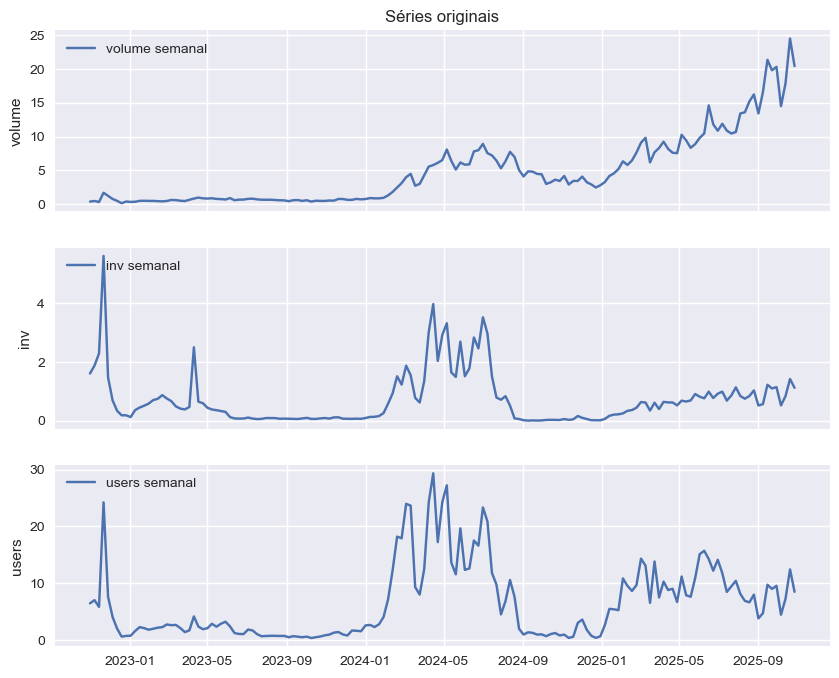

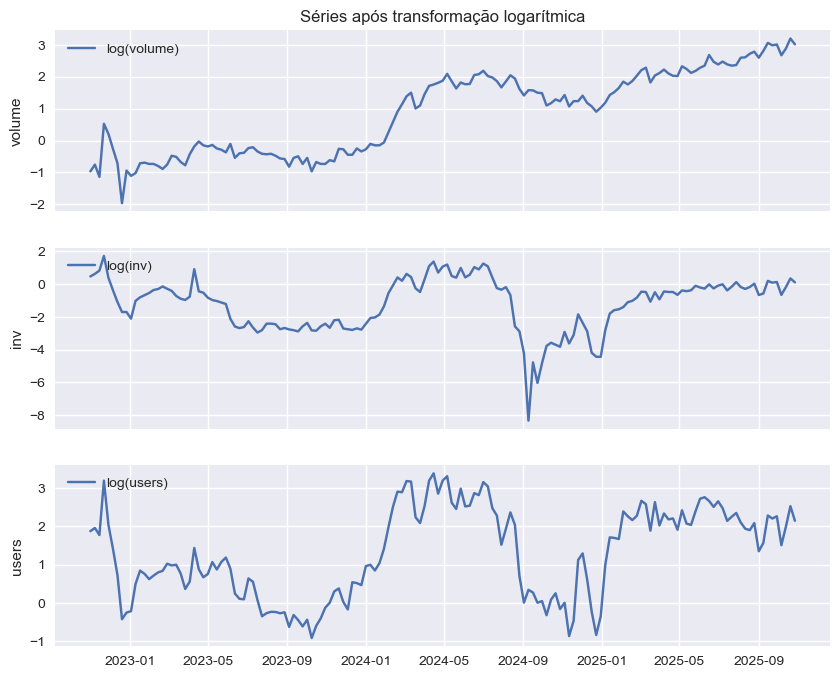

In [4]:
fig, axes = plt.subplots(len(series_names), 1, figsize=(10, 8), sharex=True)
for ax, name in zip(axes, series_names):
    ax.plot(series_dict[name], label=f"{name} semanal")
    ax.set_ylabel(name)
    ax.legend(loc="upper left")
axes[0].set_title("Séries originais")
plt.show()

# Aplicamos a transformação logarítmica para estabilizar a variância
log_transformer = LogTransform()
log_series_dict = {}
for name in series_names:
    y = series_dict[name].astype(float).values
    y_log = log_transformer.transform(y)
    log_series_dict[name] = pd.Series(y_log, index=series_dict[name].index)

fig, axes = plt.subplots(len(series_names), 1, figsize=(10, 8), sharex=True)
for ax, name in zip(axes, series_names):
    ax.plot(log_series_dict[name], label=f"log({name})")
    ax.set_ylabel(name)
    ax.legend(loc="upper left")
axes[0].set_title("Séries após transformação logarítmica")
plt.show()


Criamos, então, um **avaliador** para medir a qualidade de uma transformação no conjunto de dados, na medida em que ela consegue deixar a série mais próxima de uma série estacionária. Internamente, ele aplica o teste *Augmented Dickey-Fuller (ADF)*, que é comumente usado para testar justamente essa característica.

Note que o teste ADF verifica apenas **estacionariedade**; para investigar se ainda há **autocorrelação significativa**, também vamos inspecionar os gráficos de **função de autocorrelação (ACF)** antes e depois das transformações.

In [5]:
transform_evaluator = TransformEvaluator()

transforms = []


Nesse caso, consideraremos duas etapas de transformação:

1. **Transformação logarítmica**: usada principalmente para **estabilizar a variância** nas séries (reduz a dependência da variância em relação ao nível da série).

2. **Diferença**: aplicada após o log, com o objetivo de **remover a tendência** remanescente e aproximar a série de um processo estacionário.

In [6]:
# Implementamos as mesmas ideias usando as classes de pré-processamento
logdiff_series_dict = {}

for series_name, series in series_dict.items():
    # Diferença simples em escala original (para comparação)
    diff_series = series.diff().dropna()

    # Diferença do log usando o método em model/preprocessor.py
    logdiff_transformer = LogDiffTransform()
    y = series.astype(float).values
    y_logdiff = logdiff_transformer.transform(y)
    logdiff_series = pd.Series(y_logdiff, index=series.index[1:])  # perde a primeira observação

    # Salvamos para análise posterior
    if series_name not in logdiff_series_dict:
        logdiff_series_dict[series_name] = {}
    logdiff_series_dict[series_name]["Diferença de primeira ordem"] = diff_series
    logdiff_series_dict[series_name]["Diferença do log(x)"] = logdiff_series

    # Avaliamos com o teste ADF
    transforms.append(
        transform_evaluator.evaluate(diff_series, "Diferença de primeira ordem", series_name)
    )
    transforms.append(
        transform_evaluator.evaluate(logdiff_series, "Diferença do log(x)", series_name)
    )


In [7]:
results = pd.DataFrame(transforms).sort_values(["series", "p_value"])
results


,series,transform,p_value,test_stat,n_obs
3,inv,Diferença do log(x),1.947030e-26,-14.178507,155
2,inv,Diferença de primeira ordem,8.077797e-23,-12.284635,154
5,users,Diferença do log(x),4.227659e-18,-10.261388,154
4,users,Diferença de primeira ordem,2.878416e-12,-7.965139,152
1,volume,Diferença do log(x),2.549212e-07,-5.917731,151
0,volume,Diferença de primeira ordem,4.020645e-06,-5.364465,151


Avaliando os p-valores, temos que a diferença do logaritmo parece ser a melhor transformação.

In [8]:
best_per_series = (
    results.sort_values("p_value").groupby("series").first().reset_index()
)
for _, row in best_per_series.iterrows():
    print(
        f"Série {row.series}: {row.transform} -> p-valor {row.p_value:.4f}, estatística {row.test_stat:.3f}"
    )

best_per_series


Série inv: <bound method Series.transform of series                       inv
transform    Diferença do log(x)
p_value                      0.0
test_stat             -14.178507
n_obs                        155
Name: 0, dtype: object> -> p-valor 0.0000, estatística -14.179
Série users: <bound method Series.transform of series                     users
transform    Diferença do log(x)
p_value                      0.0
test_stat             -10.261388
n_obs                        154
Name: 1, dtype: object> -> p-valor 0.0000, estatística -10.261
Série volume: <bound method Series.transform of series                    volume
transform    Diferença do log(x)
p_value                      0.0
test_stat              -5.917731
n_obs                        151
Name: 2, dtype: object> -> p-valor 0.0000, estatística -5.918


,series,transform,p_value,test_stat,n_obs
0,inv,Diferença do log(x),1.947030e-26,-14.178507,155
1,users,Diferença do log(x),4.227659e-18,-10.261388,154
2,volume,Diferença do log(x),2.549212e-07,-5.917731,151


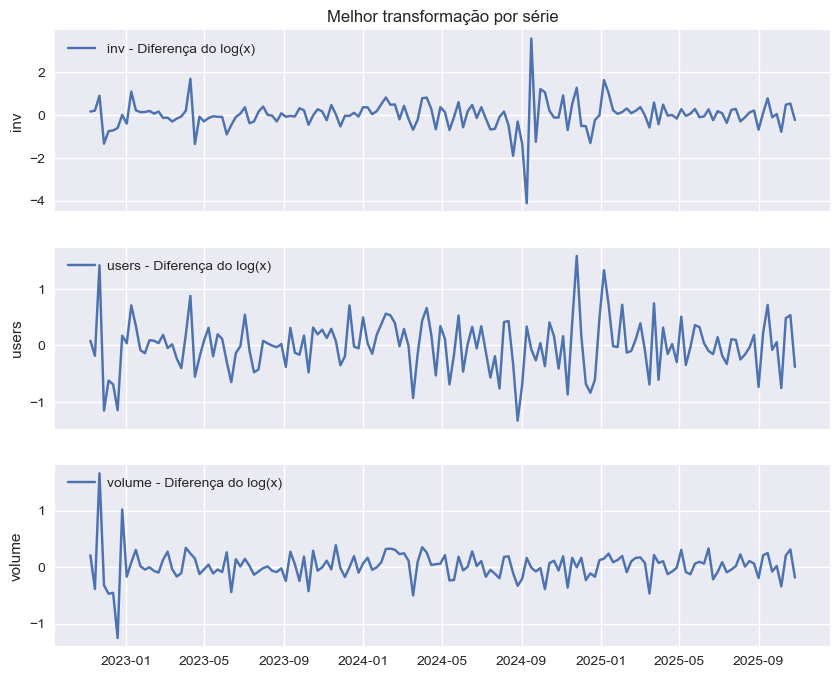

In [9]:
fig, axes = plt.subplots(len(best_per_series), 1, figsize=(10, 8), sharex=True)
axes = np.atleast_1d(axes)
for ax, row in zip(axes, best_per_series.itertuples()):
    best_series = logdiff_series_dict[row.series][row.transform]
    ax.plot(best_series, label=f"{row.series} - {row.transform}")
    ax.set_ylabel(row.series)
    ax.legend(loc="upper left")
axes[0].set_title("Melhor transformação por série")
plt.show()


Agora avaliamos a **autocorrelação** antes e depois da transformação de log-diferença.

A ideia é verificar se a transformação não só torna a série estacionária segundo o ADF, mas também **reduz a autocorrelação** em defasagens mais altas, o que é desejável para muitos modelos de série temporal.


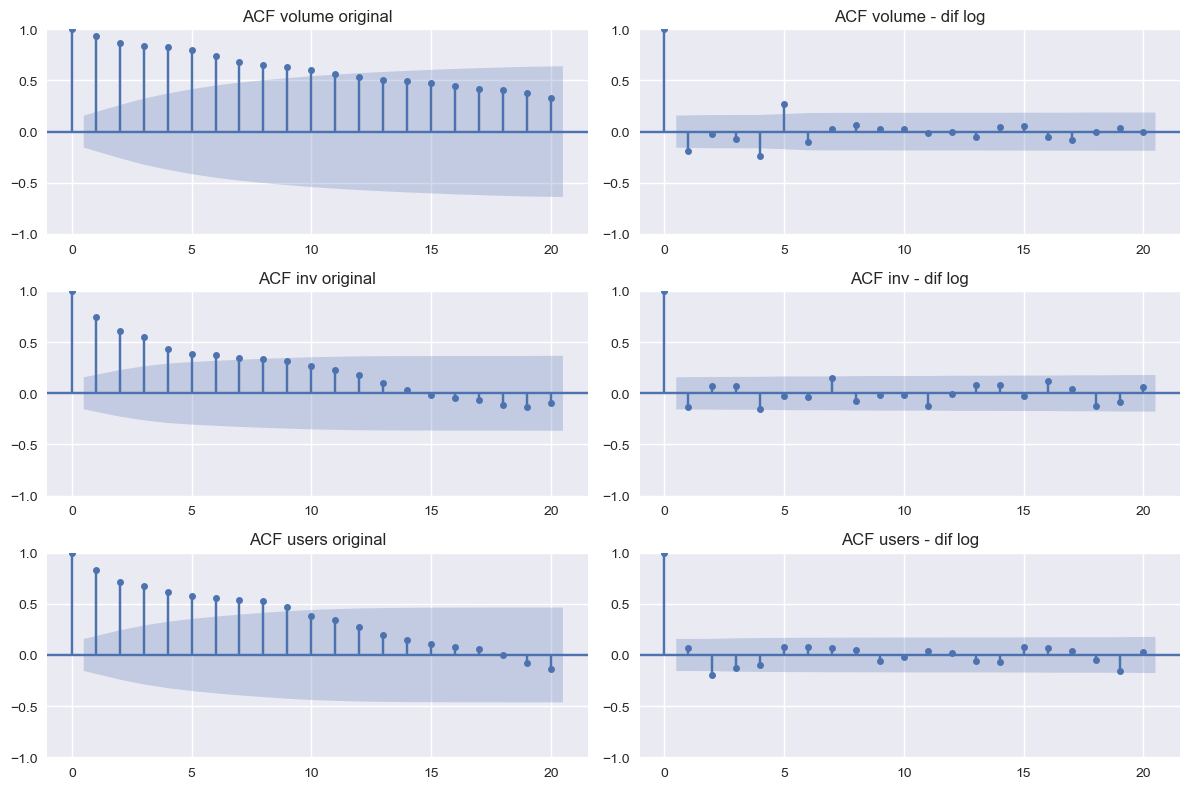

In [10]:
fig, axes = plt.subplots(len(series_names), 2, figsize=(12, 8))

for i, name in enumerate(series_names):
    # Série original
    plot_acf(series_dict[name].dropna(), ax=axes[i, 0], lags=20)
    axes[i, 0].set_title(f"ACF {name} original")

    # Série transformada (diferença do log)
    transformed = logdiff_series_dict[name]["Diferença do log(x)"].dropna()
    plot_acf(transformed, ax=axes[i, 1], lags=20)
    axes[i, 1].set_title(f"ACF {name} - dif log")

plt.tight_layout()
plt.show()



Após a transformação, observa-se que a autocorrelação nas primeiras defasagens **diminui consideravelmente** em todas as séries, especialmente em defasagens elevadas, indicando redução da memória de longo prazo. Isso sugere que a transformação de diferença do log foi **efetiva** em eliminar tendências e tornar as séries mais próximas de estacionárias, já que a maioria das autocorrelações rapidamente se aproxima de zero após poucos lags. 

In [11]:
from model.preprocessor import LogDiffTransform
from model.ar_ma_models import ARModel, MAModel
from model.visualizer import TimeSeriesVisualizer
from model.exp_smooth_models import SimpleExponentialSmoothingModel, HoltLinearTrendModel, HoltWintersAdditiveModel, HoltWintersMultiplicativeModel

def select_ar_model(y: np.ndarray, max_lags: int = 10) -> ARModel:
    best_model = None
    best_aic = np.inf
    for p in range(1, max_lags + 1):
        diff_ar = LogDiffTransform()
        y_train_diff = diff_ar.transform(y)
        model = ARModel(lags=p)
        model.fit(y_train_diff)
        if model.get_params().get("aic", np.inf) < best_aic:
            best_aic = model.get_params().get("aic", np.inf)
            best_model = model
    return best_model


def select_ma_model(y: np.ndarray, max_order: int = 10) -> MAModel:
    best_model = None
    best_aic = np.inf
    for q in range(1, max_order + 1):
        diff_ma = LogDiffTransform()
        y_train_diff = diff_ma.transform(y)
        model = MAModel(order=q)
        model.fit(y_train_diff)
        if model.get_params().get("aic", np.inf) < best_aic:
            best_aic = model.get_params().get("aic", np.inf)
            best_model = model
    return best_model

def select_ses_model(y: np.ndarray) -> SimpleExponentialSmoothingModel:
    diff = LogDiffTransform()
    y_diff = diff.transform(y)

    model = SimpleExponentialSmoothingModel()
    model.fit(y_diff)

    return model


def select_holt_model(y: np.ndarray) -> HoltLinearTrendModel:
    candidates = [
        HoltLinearTrendModel(damped_trend=False),
        HoltLinearTrendModel(damped_trend=True)
    ]

    best_model = None
    best_aic = np.inf

    diff = LogDiffTransform()
    y_diff = diff.transform(y)

    for m in candidates:
        m.fit(y_diff)
        aic = m.get_params().get("aic", np.inf)
        if aic < best_aic:
            best_aic = aic
            best_model = m

    return best_model


def select_hw_additive(y: np.ndarray, seasonal_candidates: list) -> HoltWintersAdditiveModel:
    best_model = None
    best_aic = np.inf

    for m in seasonal_candidates:
        model = HoltWintersAdditiveModel(seasonal_periods=m)
        model.fit(y)
        aic = model.get_params().get("aic", np.inf)

        if aic < best_aic:
            best_aic = aic
            best_model = model

    return best_model


def select_hw_multiplicative(y: np.ndarray, seasonal_candidates: list) -> HoltWintersMultiplicativeModel:
    best_model = None
    best_aic = np.inf

    for m in seasonal_candidates:
        model = HoltWintersMultiplicativeModel(seasonal_periods=m)
        model.fit(y)
        aic = model.get_params().get("aic", np.inf)

        if aic < best_aic:
            best_aic = aic
            best_model = model

    return best_model


=== Melhor AR ===: lags=5, AIC=-35.73


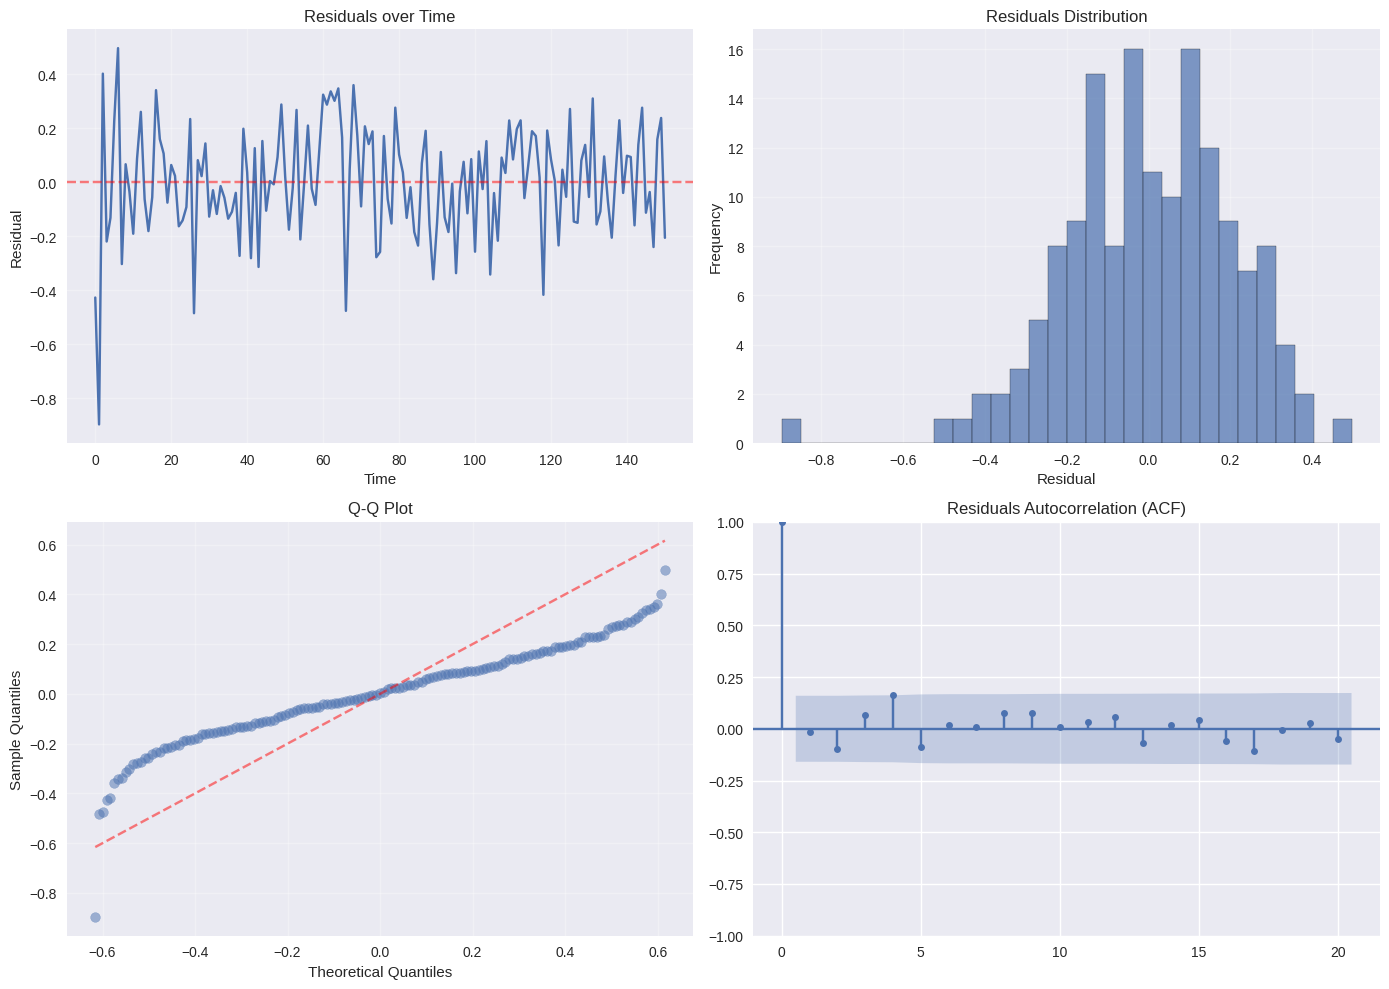

=== Melhor MA ===: order=5, AIC=-26.39


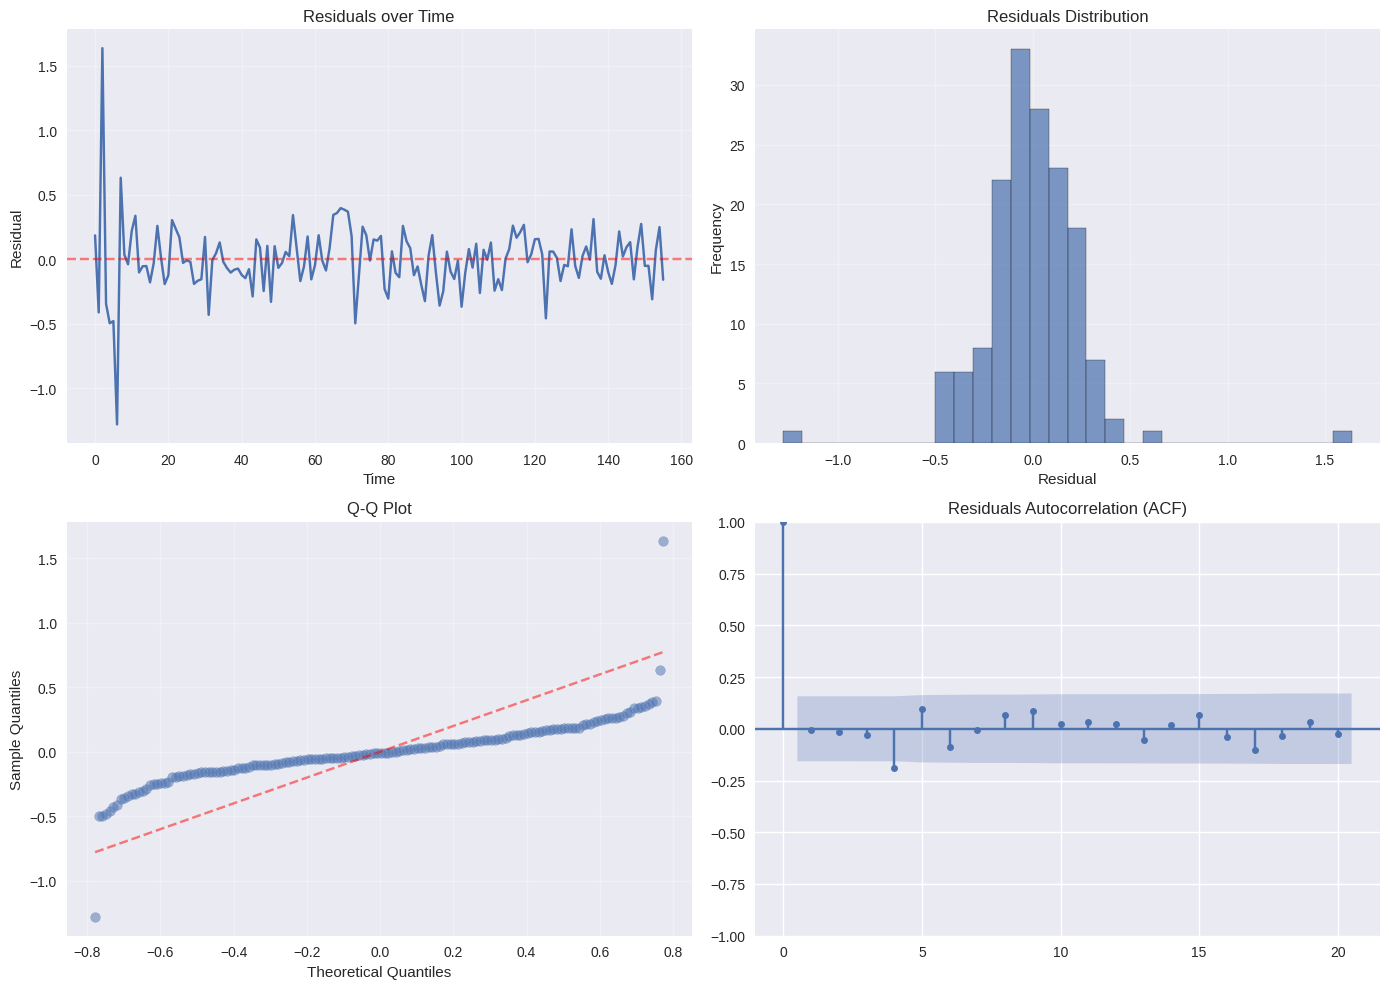

=== SES ===: AIC=-397.44


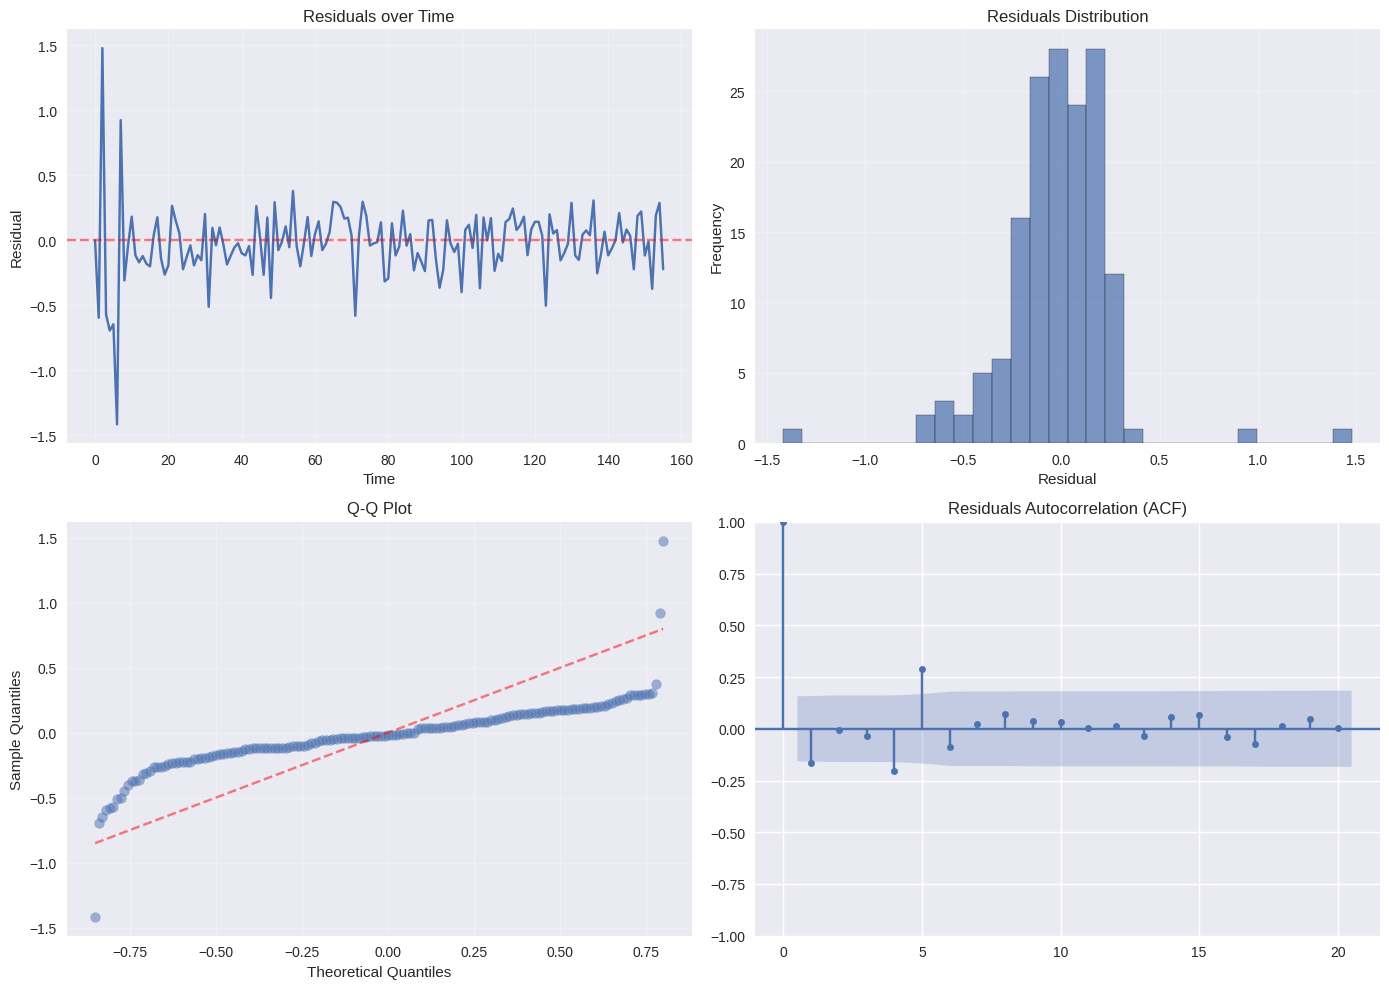

=== Melhor Holt ===: damped=True, AIC=-342.38


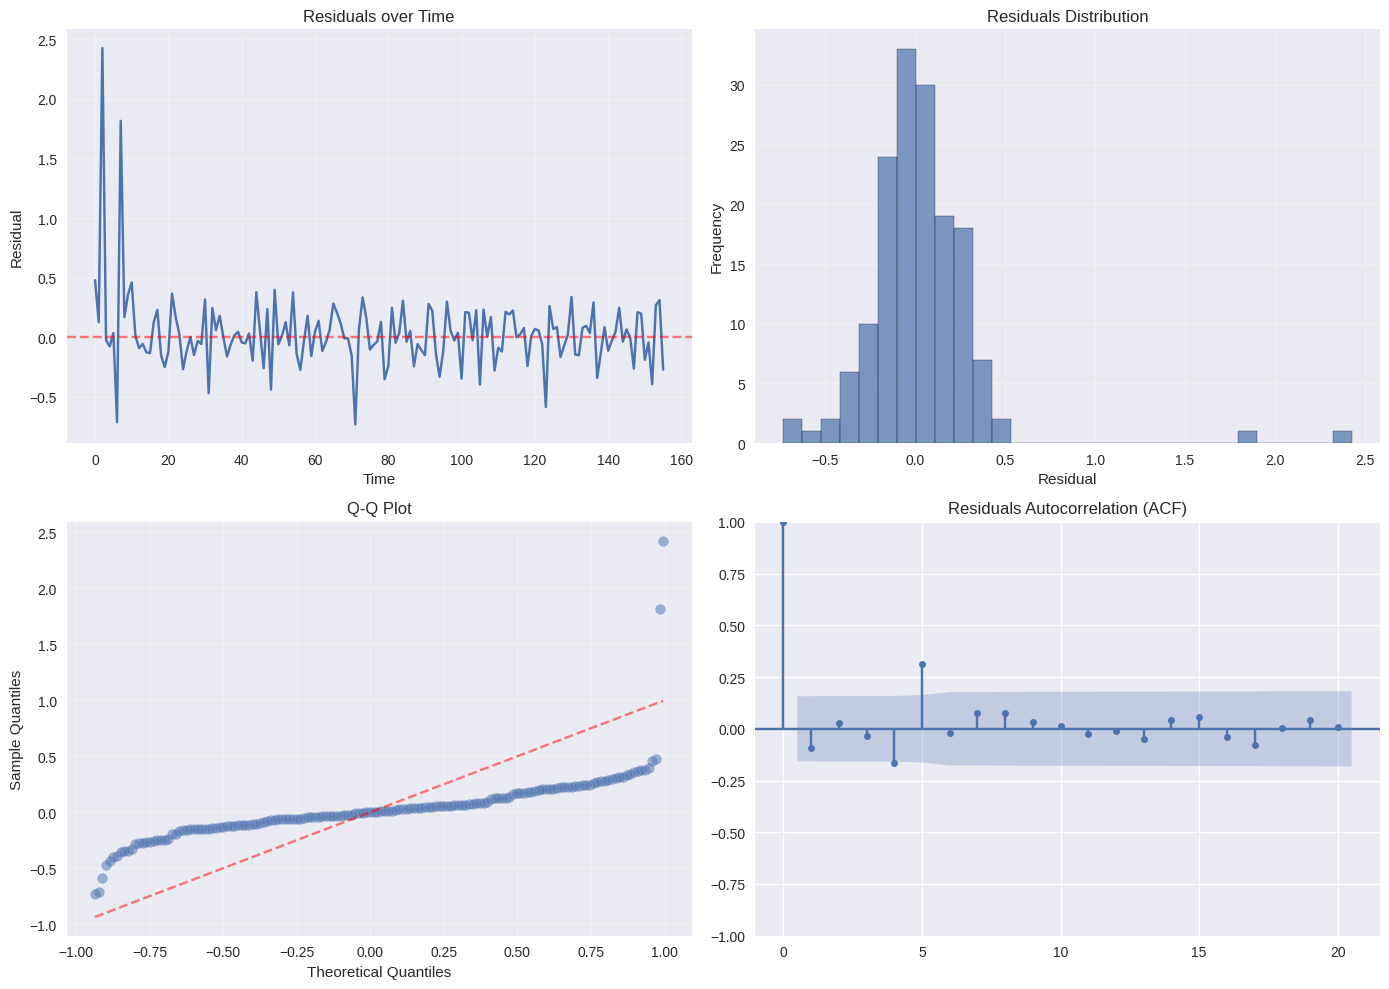

=== Melhor Holt-Winters Aditivo ===: seazonal_periods=4, AIC=82.23


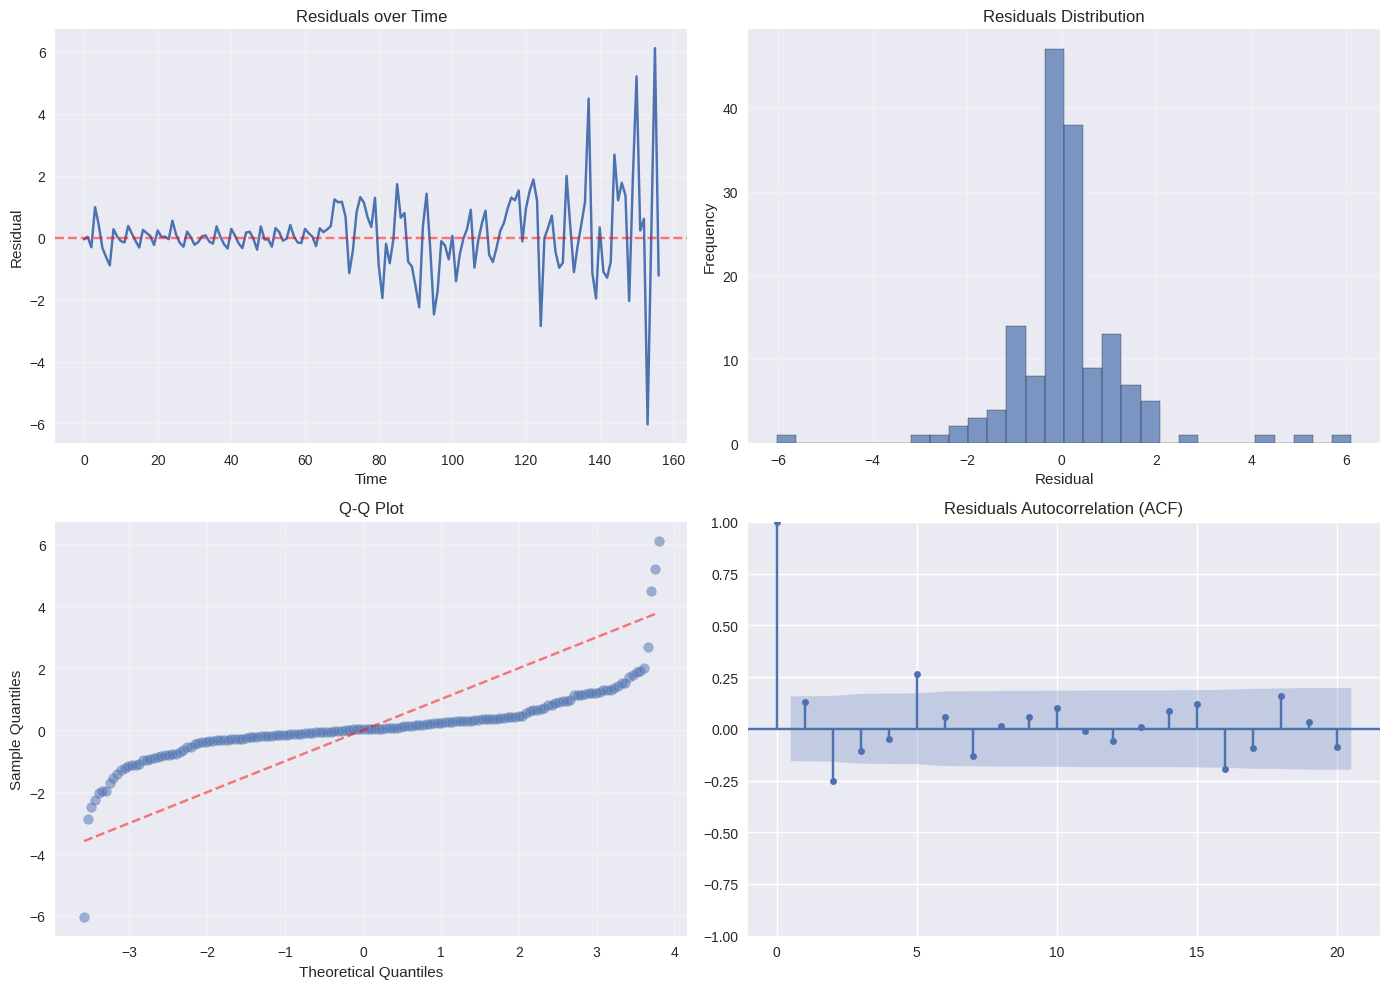

=== Melhor Holt-Winters Multiplicativo ===: seazonal_periods=4, AIC=-156.33


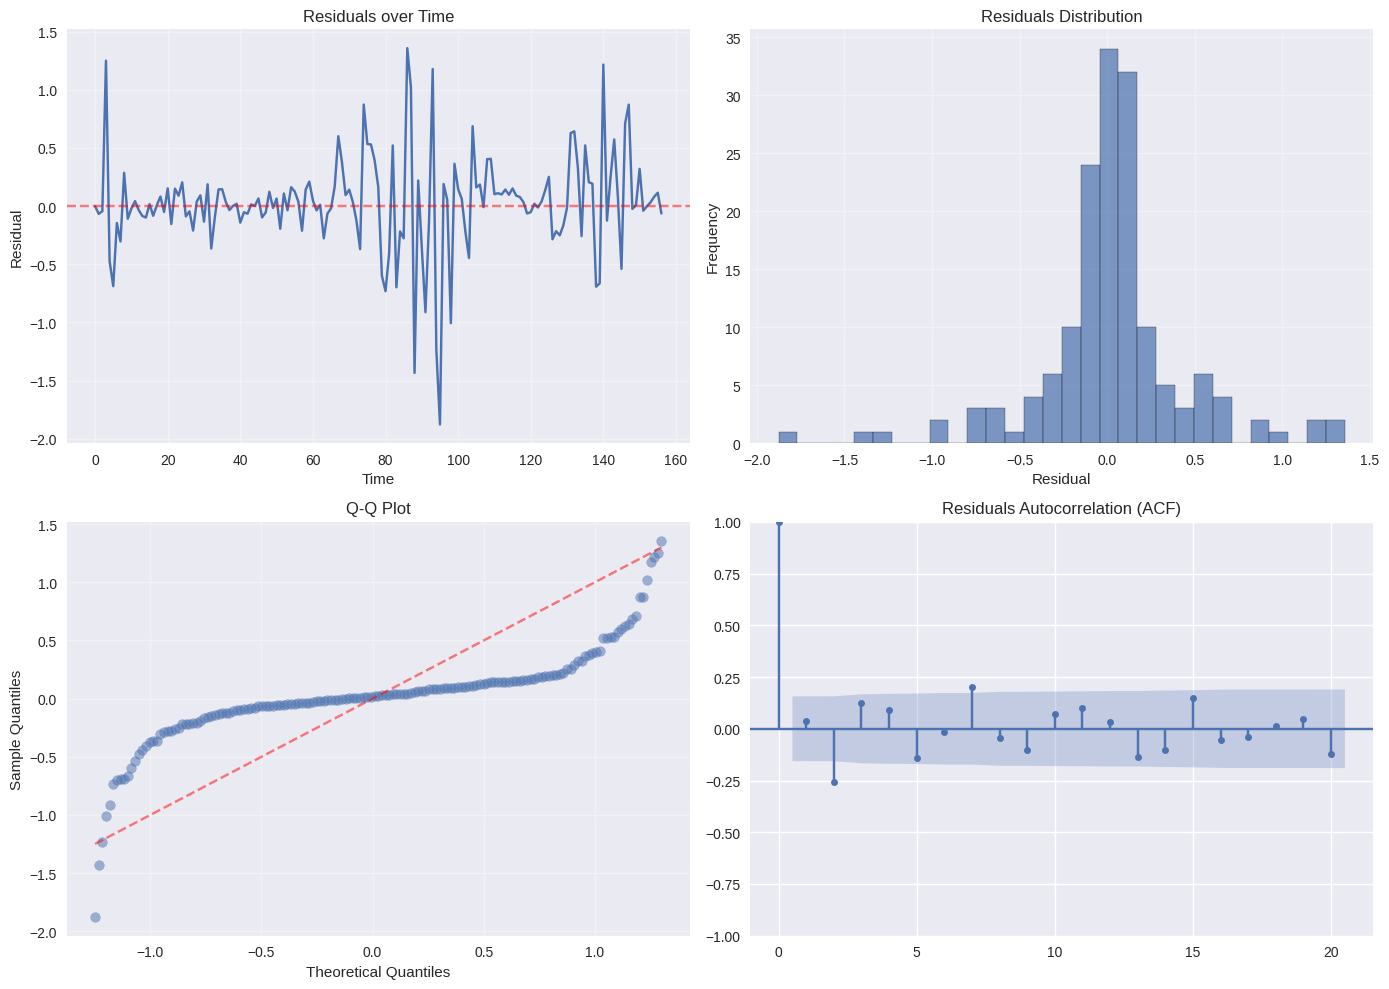

In [30]:
viz = TimeSeriesVisualizer(figsize=(12, 5))
seasonal_list = [4, 13, 26, 52]

y = loader.get_series("volume")

best_ar = select_ar_model(y, 5)
print(f"\n=== Melhor AR ===: lags={best_ar.lags}, AIC={best_ar.get_params().get('aic'):.2f}")
viz.plot_residuals(best_ar.residuals)

best_ma = select_ma_model(y, 5)
print(f"=== Melhor MA ===: order={best_ma.order}, AIC={best_ma.get_params().get('aic'):.2f}")
viz.plot_residuals(best_ma.residuals)

best_ses = select_ses_model(y)
print(f"=== SES ===: AIC={best_ses.get_params().get('aic'):.2f}")
viz.plot_residuals(best_ses.residuals)

best_holt = select_holt_model(y)
print(f"=== Melhor Holt ===: damped={best_holt.damped_trend}, AIC={best_holt.get_params().get('aic'):.2f}")
viz.plot_residuals(best_holt.residuals)

best_hw_add = select_hw_additive(y, seasonal_candidates=seasonal_list)
print(f"=== Melhor Holt-Winters Aditivo ===: seazonal_periods={best_hw_add.seasonal_periods}, AIC={best_hw_add.get_params().get('aic'):.2f}")
viz.plot_residuals(best_hw_add.residuals)

best_hw_mul = select_hw_multiplicative(y, seasonal_candidates=seasonal_list)
print(f"=== Melhor Holt-Winters Multiplicativo ===: seazonal_periods={best_hw_add.seasonal_periods}, AIC={best_hw_mul.get_params().get('aic'):.2f}")
viz.plot_residuals(best_hw_mul.residuals)

Após analisar os modelos AR, MA e exponenciais, atribuindo diferentes parâmetros e avaliando o AIC entre eles podemos escolher os melhores modelos de cada caso:

AR: AIC -36

MA: AIC -26

SES: AIC -397

Holt: AIC -342

Holt-Winters Aditivo: AIC 82

Holt-Winters Multiplicativo: AIC -156

Sendo o melhor dentre todos o SES, com menor AIC.

Aqui vale dizer que a sazonalidade encontrada anteriormente foi de 56, mas considerando o AIC obtivemos uma sazonalidade 4, indicando que pode haver algum padrão mensal também.

# Considerando as variáveis exógenas nos melhores MA e AR

In [31]:
import numpy as np
from model.diagnostics import WalkForwardDiagnostics

transformer = LogDiffTransform()

volume = transformer.transform(loader.get_series("volume"))
users = transformer.transform(loader.get_series("users"))
inv = transformer.transform(loader.get_series("inv"))

full_exog = np.column_stack((users, inv))

diagnostics = WalkForwardDiagnostics(min_train_size=52, horizon=12, step_size=1)

results_ar = diagnostics.diagnose(best_ar, volume, fit_params={"exog": full_exog}, predict_params={"exog": full_exog})
results_ma = diagnostics.diagnose(best_ma, volume, fit_params={"exog": full_exog}, predict_params={"exog": full_exog})

results_df = pd.DataFrame({
    "AR Model": results_ar,
    "MA Model": results_ma
})

aics = {
    "AR Model": best_ar.get_params().get("aic"),
    "MA Model": best_ma.get_params().get("aic")
}
results_df.loc["AIC"] = aics
results_df

,AR Model,MA Model
MAE,0.135797,0.103062
RMSE,0.183854,0.139121
MAPE,219.537222,104.185853
AIC,-85.690594,-90.083292
